# Experiment 2: Unstable Confounder

In this experiment, we use a simplified causal graph consisting of three nodes: immune state, sex, and AIRR (same as Experiment 1). Here we change the distribution of the confounder between the training and test, and show how it influences the prediction performance.

The set up is the same as in Experiment 1, except we change the p value in the binomial distribution of the confounder between training and test.

Immune state is a binary variable and can have values `True` or `False` to indicate if an individual is diseased or healthy. Confounder (sex) also in this setting has two values. AIRR is a set of sequences simulated based on the values of the immune state and the confounder for the given individual.

Steps:

1. Simulate training and test dataset from a causal graph to include: confounder (sex, implemented by creating repertoires with different OLGA models), immune state (implemented by implanting a signal in the repertoire)

2. Train an ML model (here: logistic regression on repertoires represented by the k-mer frequencies) on the train set and assess its performance on the test set in the presence of confounder where the confounder distribution changes between training and test.

Software used: 

- DagSim for simulation of the causal graph; 
- immuneML v2.1 for implanting signal in AIRRs and for training and assessing machine learning classifiers; 
- OLGA for simulation of naive AIRRs

## Step 1: AIRR simulation from a causal graph

In [1]:
import os
import yaml
import dagsim.baseDS as ds
import numpy as np
from pathlib import Path
from util.dataset_util import make_AIRR_dataset, make_dataset, setup_path
from util.implanting import make_immune_state_signal, make_confounding_signal
from util.experiment1 import get_immune_state, get_confounder, get_repertoire
from immuneML.simulation.implants.Signal import Signal

In [27]:
result_path = setup_path('./experiment2/')
data_path = setup_path("./experiment2/data/")

train_example_count = 200
test_example_count = 50

# immune state: two binomial distributions depending on the confounder value with probability of success p
immune_state_p_conf1 = 0.75 # for confounder = C1
immune_state_p_conf2 = 0.25 # for confounder = C2

# confounder: binomial distribution with probability of success p
confounder_p_train = 0.3
confounder_p_test = 0.7

# other parameters
immune_state_implanting_rate = 0.01 # percentage of repertoire sequences to include immune state signal
confounding_implanting_rate = 0.01
sequence_count = 2000 # number of sequences in one repertoire

Removing experiment2...


/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/dagsim/baseDS.py:219: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



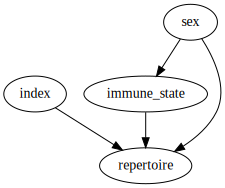

In [28]:
# define the immune signal that will represent the immune state

immune_state_signal = make_immune_state_signal()
confounding_signal = make_confounding_signal()

# define nodes of the causal graph

index_node = ds.Generic(name="index", function=np.arange, size_field="stop")

confounder_node = ds.Generic(name="sex", function=get_confounder, arguments={"p": confounder_p_train})

immune_state_node = ds.Generic(name="immune_state", function=get_immune_state, 
                               arguments={"confounder": confounder_node, "p_conf1": immune_state_p_conf1,
                                         "p_conf2": immune_state_p_conf2})

repertoire_node = ds.Generic(name="repertoire", function=get_repertoire, 
                             arguments={"immune_state": immune_state_node, "confounder": confounder_node, 
                                        "path": data_path / "train", "sequence_count": sequence_count, 
                                        "immune_state_signal": immune_state_signal, 
                                        "confounding_signal": confounding_signal, "seed": index_node, 
                                        'immune_state_implanting_rate': immune_state_implanting_rate, 
                                        'confounding_implanting_rate': confounding_implanting_rate})

# make a causal graph using DagSim and show it graphically

graph = ds.Graph(name="graph_experiment_2", 
                 list_nodes=[index_node, confounder_node, immune_state_node, repertoire_node])
graph.draw()

In [29]:
# simulate a dataset using the graph

study_cohort_data = graph.simulate(num_samples=train_example_count, 
                                   csv_name=str(data_path / "train/study_cohort"))

# make an AIRR dataset from the generated repertoires to be used for training

train_dataset = make_dataset(repertoire_paths=study_cohort_data["repertoire"], path=data_path / 'train', 
                             dataset_name="experiment2_train", 
                             signal_names=[immune_state_signal.id, confounder_node.name])

# make a test dataset

repertoire_node.additional_parameters['path'] = data_path / 'test' # update result_path: to be removed with DagSim update
confounder_node.additional_parameters['p'] = confounder_p_test # update the confounder distribution parameter for test

test_data = graph.simulate(num_samples=test_example_count, csv_name=str(data_path / "test/test_cohort"))

test_dataset = make_dataset(repertoire_paths=test_data["repertoire"], path=data_path / 'test', 
                            dataset_name="experiment2_test", 
                            signal_names=[immune_state_signal.id, confounder_node.name])

# merge datasets (but the distinction between train and test will be kept)

dataset = make_AIRR_dataset(train_dataset, test_dataset, data_path / 'full_dataset')

## Step 2: train an ML model and assess performance

In [30]:
specs = {
    "definitions": {
        "datasets": {
            "dataset1": {
                "format": 'AIRR',
                "params": {
                    "path": str(data_path / 'full_dataset'),
                    "metadata_file": str(data_path / 'full_dataset/metadata.csv')
                }
            }
        },
        "encodings": {
            "kmer_frequency": {
                "KmerFrequency": {"k": 3}
            }
        },
        "ml_methods": {
            "logistic_regression": {
                "LogisticRegression": {
                    "penalty": "l1",
                    "C": [0.01, 0.1, 1, 10, 100],
                    "show_warnings": False
                },
                "model_selection_cv": True,
                "model_selection_n_folds": 5
            }
        },
        "reports": {
            "motif_recovery": { # to check how much coefficients overlap with the immune state signal that was implanted
                "MotifSeedRecovery": {
                    "implanted_motifs_per_label": {
                        "immune_state": {
                            "seeds": ["EQY", "QPQ"],
                            "hamming_distance": False,
                            "gap_sizes": [0] # no gaps
                        },
                        "sex": {
                            "seeds": ["ADR", "ATS"],
                            "hamming_distance": False,
                            "gap_sizes": [0] # no gaps
                        }
                    }
                }
            },
            "coefficients": {
                "Coefficients": { # show top 25 logistic regression coefficients and what k-mers they correspond to
                    "coefs_to_plot": ['n_largest'],
                    "n_largest": [25]
                }
            },
            "feature_comparison_with_confounder": {
                "FeatureComparison": {
                    "comparison_label": "immune_state",
                    "color_grouping_label": "sex",
                    "show_error_bar": False
                }
            },
            "feature_comparison_no_confounder": {
                "FeatureComparison": {
                    "comparison_label": "immune_state",
                    "show_error_bar": False
                }
            }
        }
    },
    "instructions": {
        'train_ml': {
            "type": "TrainMLModel",
            "assessment": { # ensure here that train and test dataset are fixed, as per simulation
                "split_strategy": "manual",
                "split_count": 1,
                "manual_config": {
                    "train_metadata_path": str(data_path / "train/experiment2_train_metadata.csv"),
                    "test_metadata_path": str(data_path / "test/experiment2_test_metadata.csv")
                },
                "reports": {
                    "models": ["coefficients", "motif_recovery"],
                    "encoding": ["feature_comparison_with_confounder", "feature_comparison_no_confounder"]
                }
            },
            "selection": {
                "split_strategy": "k_fold",
                "split_count": 5,
                "reports": {
                    "models": ["coefficients", "motif_recovery"],
                    "encoding": ["feature_comparison_with_confounder", "feature_comparison_no_confounder"]
                }
            },
            "settings": [
                {"encoding": "kmer_frequency", "ml_method": "logistic_regression"}
            ],
            "dataset": "dataset1",
            "refit_optimal_model": False,
            "labels": ["immune_state"],
            "optimization_metric": "balanced_accuracy",
            "metrics": ['log_loss', 'auc']
        }
    }
}

ml_result_path = setup_path("./experiment2/ml_result/")
specification_path = ml_result_path / "specs.yaml"

with open(specification_path, "w") as file:
    yaml.dump(specs, file)

In [31]:
# run immuneML with the specs file

from immuneML.app.ImmuneMLApp import ImmuneMLApp

output_path = ml_result_path / "result/"

app = ImmuneMLApp(specification_path = specification_path, result_path = output_path)
result = app.run()

print("The results are located under ./experiment2/")

2021-12-02 14:46:20.502876: Setting temporary cache path to experiment2/ml_result/result/cache
2021-12-02 14:46:20.503426: ImmuneML: parsing the specification...

2021-12-02 14:46:58.742746: Full specification is available at experiment2/ml_result/result/full_specs.yaml.

2021-12-02 14:46:58.743510: ImmuneML: starting the analysis...

2021-12-02 14:46:58.744005: Instruction 1/1 has started.
2021-12-02 14:46:58.816664: Training ML model: running outer CV loop: started split 1/1.

2021-12-02 14:46:58.917146: Hyperparameter optimization: running the inner loop of nested CV: selection for label immune_state (label 1 / 1).

2021-12-02 14:46:58.918448: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-12-02 14:46:58.919822: Encoding started...


sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf5b898d00>



2021-12-02 14:47:10.744703: Encoding finished.
2021-12-02 14:47:10.745189: ML model training started...
2021-12-02 14:48:02.727659: ML model training finished.
2021-12-02 14:48:17.495802: Encoding started...
2021-12-02 14:48:22.091904: Encoding finished.
2021-12-02 14:48:30.001289: Completed hyperparameter setting kmer_frequency_logistic_regression.

2021-12-02 14:48:30.003110: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-12-02 14:48:30.005020: Encoding started...
2021-12-02 14:48:36.776583: Encoding finished.
2021-12-02 14:48:36.777126: ML model training started...
2021-12-02 14:49:29.062632: ML model training finished.
2021-12-02 14:49:43.316115: Encoding started...
2021-12-02 14:49:46.921450: Encoding finished.
2021-12-02 14:49:54.438409: Completed hyperparameter setting kmer_frequency_logistic_regression.

2021-12-02 14:49:54.440501: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-12-02 14:49:54.441586: Encoding started

In [32]:
from util.plotting import plot_validation_vs_test_performance

plot_validation_vs_test_performance(iml_result=result, result_path=ml_result_path)

In [33]:
# show what the model has learned

from IPython.display import IFrame


IFrame(src=str(ml_result_path / "result/HTML_output/train_ml_split_1_immune_state_kmer_frequency_logistic_regression_optimal_reports_ml_method_coefficients_largest_25_coefficients.html"),  width=700, height=600)



In [34]:
# feature comparison across classes grouped by confounder value

# TRAIN DATA (200 repertoires)

IFrame(src=str(ml_result_path / "result/HTML_output/train_ml_split_1_immune_state_kmer_frequency_logistic_regression_optimal_reports_encoding_train_feature_comparison_with_confounder_feature_comparison.html"),  width=700, height=600)



In [35]:
# TEST DATA (50 repertoires)

IFrame(src=str(ml_result_path / "result/HTML_output/train_ml_split_1_immune_state_kmer_frequency_logistic_regression_optimal_reports_encoding_test_feature_comparison_with_confounder_feature_comparison.html"),  width=700, height=600)


In [36]:
# feature comparison across classes without confounder value

# TRAIN DATA (200 repertoires):

IFrame(src=str(ml_result_path / "result/HTML_output/train_ml_split_1_immune_state_kmer_frequency_logistic_regression_optimal_reports_encoding_train_feature_comparison_no_confounder_feature_comparison.html"),  width=700, height=600)


In [37]:
# TEST DATA (50 repertoires)

IFrame(src=str(ml_result_path / "result/HTML_output/train_ml_split_1_immune_state_kmer_frequency_logistic_regression_optimal_reports_encoding_test_feature_comparison_no_confounder_feature_comparison.html"),  width=700, height=600)
